**Import required libraries and modules**

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statistics

## Step 0: Data Inspection

In [2]:
# Import dataset
df = pd.read_csv("../raw_data.csv")

In [3]:
# Inspect dataset
df.shape

(26147, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26147 entries, 0 to 26146
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   zip_code             26147 non-null  int64  
 1   commune              26147 non-null  object 
 2   province             26147 non-null  object 
 3   type_of_property     26147 non-null  int64  
 4   subtype_of_property  26147 non-null  object 
 5   price                26111 non-null  float64
 6   building_condition   19457 non-null  object 
 7   facade_number        16785 non-null  float64
 8   living_area          26147 non-null  int64  
 9   equipped_kitchen     26147 non-null  object 
 10  bedroom_nr           26147 non-null  int64  
 11  swimming_pool        26147 non-null  int64  
 12  furnished            26147 non-null  int64  
 13  open_fire            26147 non-null  int64  
 14  terrace              26147 non-null  int64  
 15  garden               26147 non-null 

In [5]:
df.value_counts("zip_code")

zip_code
8300    918
1000    626
1070    564
9000    564
1180    548
       ... 
7024      1
7033      1
7034      1
4287      1
9970      1
Name: count, Length: 875, dtype: int64

In [6]:
df.value_counts("commune")

commune
Westkapelle     918
Antwerpen       692
Bruxelles       626
Gent            564
Anderlecht      564
               ... 
Bilstain          1
Binkom            1
Basse-Bodeux      1
Baulers           1
Zillebeke         1
Name: count, Length: 849, dtype: int64

In [12]:
df.describe()

,zip_code,type_of_property,price,facade_number,living_area,bedroom_nr,swimming_pool,furnished,open_fire,terrace,garden,plot_surface
count,26147.000000,26147.000000,2.611100e+04,16785.000000,26147.000000,26147.000000,26147.000000,26147.000000,26147.000000,26147.000000,26147.000000,26147.000000
mean,5085.507821,0.394080,4.594943e+05,2.720167,143.557425,2.599648,0.019429,0.032088,0.007458,12.193942,102.666692,407.083681
std,3283.479987,0.488661,4.355173e+05,0.847971,97.351713,1.370721,0.138029,0.176237,0.086038,43.316550,676.906691,2650.878092
min,1000.000000,0.000000,2.750000e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1743.500000,0.000000,2.650000e+05,2.000000,88.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4480.000000,0.000000,3.500000e+05,2.000000,116.000000,2.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
75%,8460.000000,1.000000,4.921000e+05,3.000000,170.000000,3.000000,0.000000,0.000000,0.000000,15.000000,0.000000,255.000000
max,9992.000000,1.000000,8.900000e+06,15.000000,992.000000,25.000000,1.000000,1.000000,1.000000,3749.000000,50000.000000,160737.000000


## Step 1: Data Cleaning

### Notes on work progress regarding handling of missing values and zero values:

**Missing Values:**

* "price" column: 36 entries missing                **-> Dropped**
* "building_condition": 6690 entries missing        **-> Encoded as "Unknown" by Alek**
* "facade_number": 9362 entries missing             **-> Used median based on subtype of property**

**Zero Values:**

* "living_area": 5 entries with 0                   **-> Dropped**
* "equipped_kitchen":                               **-> 0 means no equipped kitchen**
* "bedroom_nr": 890 entries with 0                  **-> 0 means either studio apartments or mixed use buildings etc.**
* "garden": 20949 entries with 0                    **-> apr. 20% of df have a garden -> matches filter result in immoweb**
* "plot_surface": 16290 entries with 0              **-> Apartments, etc.; Does not include living area based in immoweb (undeveloped property)** 
* "building_condition"                              **-> filled with "Unknown" by Alek**


**Other:**
* "terrace":                               **-> 0 means no terrace**
* "garden":                                **->same as terrace**
* "subtype_of_property"                    **> Celina removed 'unit'**
* "building_condition"                     **> Alek reduced number of categories**
* "equipped_kitchen"                       **> Alek reduced number of categories**

In [13]:
# See summary of missing values
df.isna().sum()

zip_code                  0
commune                   0
province                  0
type_of_property          0
subtype_of_property       0
price                    36
building_condition     6690
facade_number          9362
living_area               0
equipped_kitchen          0
bedroom_nr                0
swimming_pool             0
furnished                 0
open_fire                 0
terrace                   0
garden                    0
plot_surface              0
dtype: int64

### Calculate missing value threshold and drop entries below or equal to

In [14]:
# Calculate missing value threshold
threshold = len(df) * 0.05
print(len(df))
print(int(threshold))

# Use Boolean indexing to filter for columns with missing values <= threshold and > 0
cols_to_drop = df.columns[(df.isna().sum() <= threshold) & (df.isna().sum() > 0)]

print(cols_to_drop)

# To drop missing values
df.dropna(subset=cols_to_drop, inplace=True)

26147
1307
Index(['price'], dtype='object')


### Drop zero values in "living_area"


In [15]:
# Drop rows where 'living_area' is 0
df = df[df["living_area"] != 0]

### Handling missing values in "building_condition"

Options:

* Fill with most frequent category (mode) --> No

* Fill with a placeholder (e.g. "Unknown") --> OK (Alek)

### Replace missing values in "facade_number" with median based on subtype of property

In [16]:
# Compute median facade number by subtype
facade_dict = df.groupby("subtype_of_property")["facade_number"].median().to_dict()

# Impute values
df["facade_number"] = df["facade_number"].fillna(df["subtype_of_property"].map(facade_dict))

In [17]:
df.isna().sum()

zip_code                  0
commune                   0
province                  0
type_of_property          0
subtype_of_property       0
price                     0
building_condition     6683
facade_number             0
living_area               0
equipped_kitchen          0
bedroom_nr                0
swimming_pool             0
furnished                 0
open_fire                 0
terrace                   0
garden                    0
plot_surface              0
dtype: int64

### Check for duplicates

In [18]:
# Check for duplicates and count them
num_duplicates = df.duplicated().sum()
num_duplicates

np.int64(1315)

In [19]:
# Remove duplicate rows and create cleaned df
#df_unique = df.drop_duplicates()

#### Notes on duplicates:

* 1284 duplicates found --> while scraping duplicates were eliminated, so the 1284 entries are in fact no duplicates

### Check for blank spaces

In [20]:
# Check for leading/trailing spaces in string columns

columns_with_spaces = [col for col in df.columns if df[col].dtype == 'object' and df[col].str.contains(r'^\s+|\s+$').any()]
columns_with_spaces

[]

In [21]:
# Check for multiple spaces within a string
columns_with_spaces = [col for col in df.columns if df[col].dtype == 'object' and df[col].str.contains(r'  ').any()]
columns_with_spaces

[]

**Result: no leading or trailing whitespace and no double whitespace**

### **Data Cleaning Result**

* No duplicates            -> OK
* No blank spaces          -> OK
* No empty values          -> OK
* No errors                -> OK

Notes:
* Duplicates: In the scraping code the listing id was checked to avoid duplicates; the entries in the df that appear as duplicates are new buildings that appear identical, but are in fact distinct listings

## Step 2: Data Analysis

Questions & Visualizations:

* How many rows and columns?
  26,106 rows and 17 columns
  
* What is the correlation between the variables and the price? (Why might that be?)
  
* How are variables correlated to each other? (Why?)
  
* Which variables have the greatest influence on the price? 
  
* Which variables have the least influence on the price? 
  
* How many qualitative and quantitative variables are there? 12 quantitative and 5 qualitative (commune, province, subtype of property, building_condition, equipped_kitchen)
  
* How would you transform these values into numerical values?
  * province                    -> label encoding (ordinal)
  * subtype of property         -> label encoding (ordinal)
  * building_condition          -> label encoding (ordinal)
  * equipped_kitchen           -> binary to 1 or 0 
  
* Percentage of missing values per column?  0 %

In [36]:
# Import cleaned dataset
dfc = pd.read_csv("../cleaned-data.csv")

### Shape

In [37]:
dfc.shape

(26106, 18)

### Quantitative and Qualitative Features

In [303]:
# Count quantitative (numerical) variables
quantitative_vars = df.select_dtypes(include=['int64', 'float64']).columns
num_quantitative = len(quantitative_vars)

# Count qualitative (categorical) variables
qualitative_vars = df.select_dtypes(include=['object', 'category']).columns.to_list()
num_qualitative = len(qualitative_vars)

print(f"Quantitative variables: {num_quantitative}")
print(f"Qualitative variables: {num_qualitative}")

print(f"Qualitative variables: {qualitative_vars}")

Quantitative variables: 12
Qualitative variables: 5
Qualitative variables: ['commune', 'province', 'subtype_of_property', 'building_condition', 'equipped_kitchen']


In [25]:
# Extract unique values for each column
unique_values = pd.DataFrame({col: [dfc[col].unique()] for col in df.columns})

unique_values

,zip_code,commune,province,type_of_property,subtype_of_property,price,building_condition,facade_number,living_area,equipped_kitchen,bedroom_nr,swimming_pool,furnished,open_fire,terrace,garden,plot_surface
0,"[2600, 2100, 2660, 1180, 2018, 1050, 2160, 285...","[Berchem, Deurne, Hoboken, Uccle, Antwerpen, I...","[Antwerpen, Bruxelles, West-Vlaanderen, Oost-V...","[0, 1]","[apartment, penthouse, flat studio, ground flo...","[149000.0, 248000.0, 229000.0, 470000.0, 48000...","[good, to renovate, no info, to restore]","[2.0, 3.0, 4.0, 1.0, 5.0, 15.0, 6.0]","[48, 91, 100, 179, 116, 150, 99, 125, 90, 110,...","[installed, not installed, equipped]","[1, 3, 2, 4, 0, 8, 5, 6, 7, 16, 10, 13, 9, 12,...","[0, 1]","[0, 1]","[0, 1]","[9, 2, 26, 10, 7, 1, 4, 13, 14, 8, 25, 19, 12,...","[0, 18, 29, 70, 100, 5, 90, 33, 300, 35, 280, ...","[0, 1481, 606, 185, 268, 604, 94, 553, 136, 66..."


### **Transformation of Qualitative Features**

In [87]:
dfc.columns

Index(['zip_code', 'commune', 'province', 'type_of_property',
       'subtype_of_property', 'price', 'building_condition', 'facade_number',
       'living_area', 'equipped_kitchen', 'bedroom_nr', 'swimming_pool',
       'furnished', 'open_fire', 'terrace', 'garden', 'plot_surface',
       'sub_property_group_encoded', 'living_area_bin'],
      dtype='object')

### Label Encoding of Provinces Based on Average Price per sqm (11 = Most Expensive)

In [ ]:
province_mapping = {
    'Brussels': 11,
    'West Flanders': 10,
    'Flemish Brabant': 9,
    'Antwerp': 8,
    'Walloon Brabant': 7,
    'Limburg': 6,
    'East Flanders': 5,
    'Namur': 4,
    'Liège': 3,
    'Luxembourg': 2,
    'Hainaut': 1
}

# Apply the mapping
dfc['province_encoded'] = dfc['province'].map(province_mapping)

### Label Encoding of Subtype of Property Based on Mean Price Per Subtype (5 = Most Expensive)

Grouping Similar Subtypes into Categories:

* 1 (Apartments): 'apartment', 'flat studio', 'penthouse', 'ground floor', 'loft', 'kot'
* 2 (Houses): 'house', 'bungalow', 'town house', 'manor house', 'duplex', 'triplex'
* 3 (Other): 'other property', 'mixed use building', 'service flat', 'apartment block'
* 4 (Rural): 'country cottage', 'farmhouse', 'chalet'
* 5 (Luxury Properties): 'mansion', 'castle', 'exceptional property', 'villa'

In [ ]:
# Define grouped mapping with assigned numbers
property_group_mapping = {
    'apartment': 1, 
    'flat studio': 1, 
    'penthouse': 1, 
    'ground floor': 1, 
    'loft': 1, 
    'kot': 1, 
    'triplex': 2, 
    'duplex': 2, 
    'house': 2, 
    'bungalow': 2, 
    'town house': 2, 
    'manor house': 2, 
    'mixed use building': 3, 
    'service flat': 3, 
    'other property': 3, 
    'apartment block': 3, 
    'country cottage': 4, 
    'farmhouse': 4, 
    'chalet': 4, 
    'villa': 5, 
    'mansion': 5, 
    'castle': 5, 
    'exceptional property': 5
}

# Apply the grouped mapping to the column
dfc['sub_property_group_numeric'] = dfc['subtype_of_property'].map(property_group_mapping)

**Subtypes of Apartments:**
['apartment' 'penthouse' 'flat studio' 'ground floor' 'duplex' 'loft'
 'service flat' 'kot' 'triplex' 'house' 'villa' 'apartment block'
 'mansion' 'exceptional property' 'mixed use building' 'country cottage'
 'town house' 'castle' 'bungalow' 'manor house' 'farmhouse' 'chalet'
 'other property']

### Label Encoding of Building Condition (3 = best condition)

In [ ]:
# Define the mapping based on condition quality
building_condition_mapping = {
    'good': 3,
    'no info': 2,
    'to renovate': 1,
    'to restore': 0
}

# Apply the mapping
dfc['building_condition_encoded'] = dfc['building_condition'].map(building_condition_mapping)

In [ ]:
# Load new cleaned df
# Import cleaned dataset
dfc = pd.read_csv("../cleaned-data.csv")

### Binary Encoding of Kitchen

In [ ]:
# Binary encoding of kitchen
dfc['equipped_kitchen_binary'] = dfc['equipped_kitchen'].apply(lambda x: 1 if x == 'equipped' else 0)

### Binary Encoding of Terrace

We had too many properties with terrace but without indication of terrace surface, we thus decided to encode as binary (with or without terrace)

In [ ]:
# Encode terrace as binary (Create new column)
dfc['terrace_binary'] = dfc['terrace'].apply(lambda x: 1 if x >= 1 else 0)

In [ ]:
# Convert facade number to int
dfc['facade_number'] = dfc['facade_number'].astype(int)

### **Exploring Corrleations Between All Features**

#### Defining Custom Color Map

**Color Palette:** 

#ffffff
#ececf3  *
#cbcbeb
#9d9de4
#8382d1  *
#615edb  *
#2d3880


In [ ]:
# Define custom colors
custom_colors = ['#ececf3', '#cbcbeb', '#9d9de4', '#8382d1', '#615edb', '#464F96', '#2d3880']

# Create a custom colormap
custom_cmap = ListedColormap(custom_colors)

#### Custom Labels

In [227]:
# Custom labels for features
custom_labels = {
    'type_of_property': 'Property Type',
    'facade_number': 'Facade Count',
    'living_area': 'Living Area (sqm)',
    'bedroom_nr': 'Bedrooms',
    'swimming_pool': 'Swimming Pool',
    'furnished': 'Furnished',
    'open_fire': 'Open Fire',
    'terrace': 'Terrace',
    'garden': 'Garden',
    'plot_surface': 'Plot Surface (sqm)',
    'province_encoded': 'Province',
    'sub_property_group_numeric': 'Property Subtype',
    'equipped_kitchen_binary': 'Equipped Kitchen',
    'building_condition_encoded': 'Building Condition',
}

#### **Correlation Matrix (Houses & Apartments Combined)**

In [174]:
# Show quantitative (numerical) variables
quantitative_vars = dfc.select_dtypes(include=['int64', 'float64']).columns
quantitative_vars

Index(['zip_code', 'type_of_property', 'price', 'facade_number', 'living_area',
       'bedroom_nr', 'swimming_pool', 'furnished', 'open_fire', 'terrace',
       'garden', 'plot_surface', 'province_encoded',
       'sub_property_group_numeric', 'equipped_kitchen_binary',
       'building_condition_encoded', 'terrace_binary'],
      dtype='object')

In [175]:
# Create new df for only numerical values
num_dfc_columns = ['type_of_property', 'sub_property_group_numeric', 'price', 'facade_number', 'living_area', 'bedroom_nr', 'building_condition_encoded', 'equipped_kitchen_binary', 'furnished', 'swimming_pool', 'open_fire', 'terrace', 'garden', 'plot_surface', 'province_encoded']

num_dfc = dfc[num_dfc_columns]

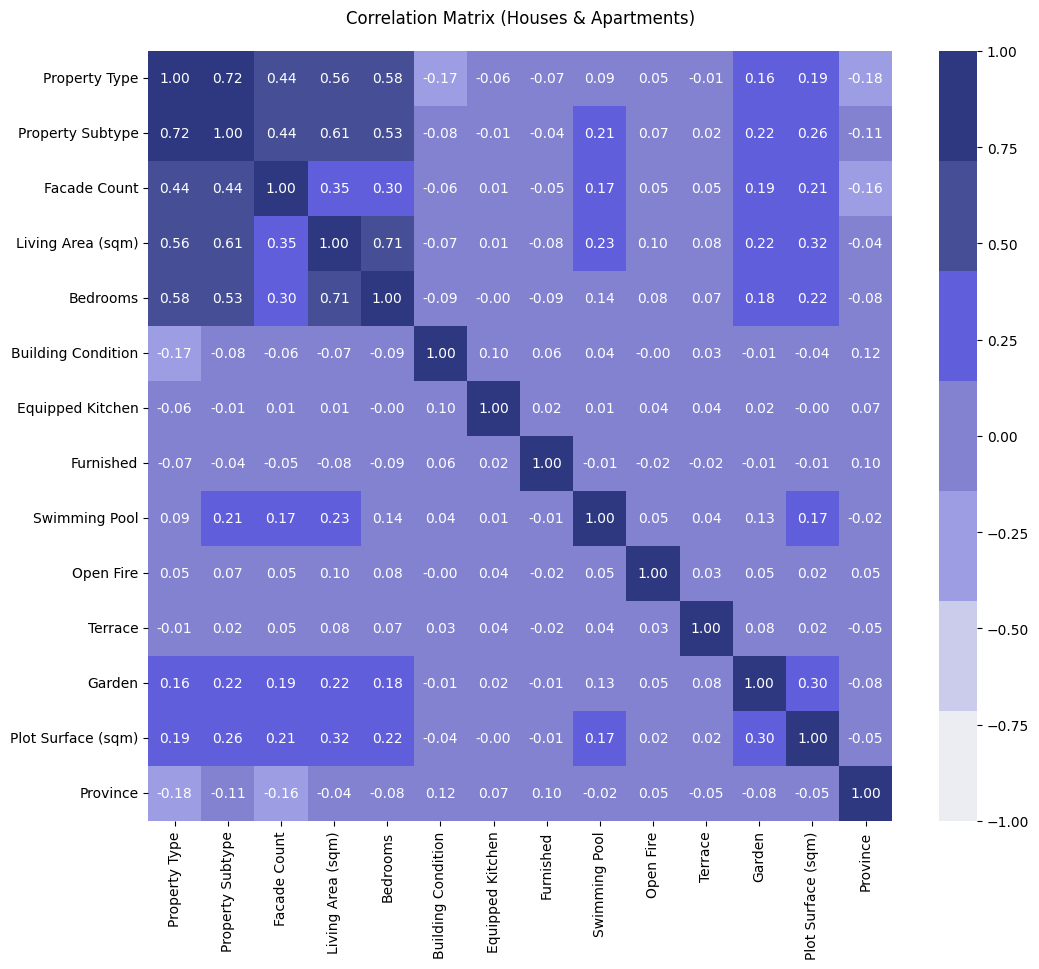

In [228]:
# Correlation matrix houses and apartments combined (excluding price)

# Excluding price
corr_features = num_dfc.corr().drop(index=['price'], columns=['price']).rename(index=custom_labels, columns=custom_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_features, annot=True, cmap=custom_cmap, fmt='.2f', vmin=-1, vmax=1)
plt.title("Correlation Matrix (Houses & Apartments)", pad=20)
plt.show()

#### Calculating Correlations for Houses and Apartments Separately

Separate computation of correlation matrix for houses and apartments each because they have fundamentally different features and pricing dynamics. Combining them could lead to misleading correlations (e.g., gardens or plot size mattering for houses but not for apartments) and obscure trends unique to each type. Analyzing them separately ensures more meaningful insights, avoids irrelevant comparisons, and improves the accuracy of any models or conclusions drawn

#### Correlation Matrix for Houses

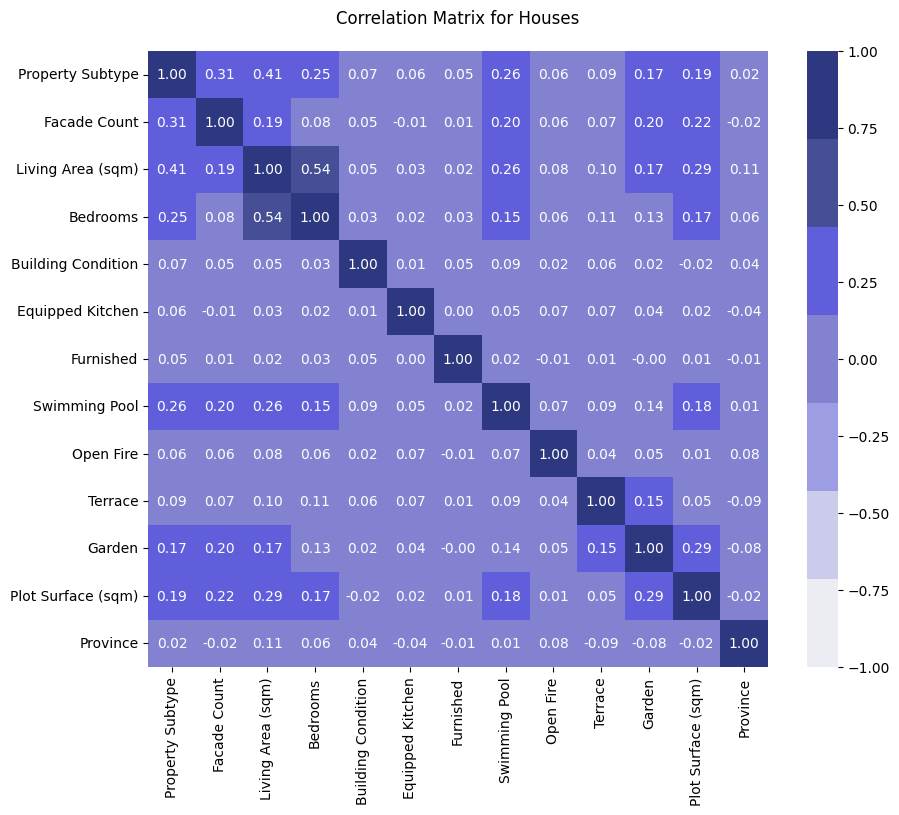

In [229]:
# Computing correlations for houses and apartments separately (excluding price)

# Filter the DataFrame for houses
corr_houses = num_dfc[num_dfc['type_of_property'] == 1].corr() \
            .drop(index=['type_of_property', 'price'], columns=['type_of_property', 'price']) \
            .rename(index=custom_labels, columns=custom_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_houses, annot=True, cmap=custom_cmap, fmt='.2f', vmin=-1, vmax=1)
plt.title("Correlation Matrix for Houses", pad=20)
plt.show()

**Evaluation of Correlations Between Features for Houses**

* Strong Relationships:
  * Living area & bedrooms (0.59): larger living areas come with more bedrooms
  * Property subtype & living area (0.41): we labeled subtypes based on price, thus more expensive subtypes tend to be bigger
  * Property subtype & facade count (0.31): The more expensive the subtype, the more facades
  * Plot surface & living area and 
  * Plot surface & garden (0.29): larger plots coincide often with larger living areas and are more likely to have gardens
  
* Other:
  * Swimming Pool & garden show some correlation with subtype and size of the property

* Weak or Negligible Relationships:
  * Furnished has an overall weak correlation with most other variables, suggesting this feature to be less likely for houses.
  * Province has slight negative correlations with features like Garden and Terrace, possibly hinting at regional trends.
  
-> The strong correlations align with real-world expectations (e.g. larger properties have more bedrooms, larger plots often include gardens). This consistency indicates that our data as well as our feature encoding and computation is logical (quality of our dataset, encoding and computation)

#### Correlation Matrix for Apartments

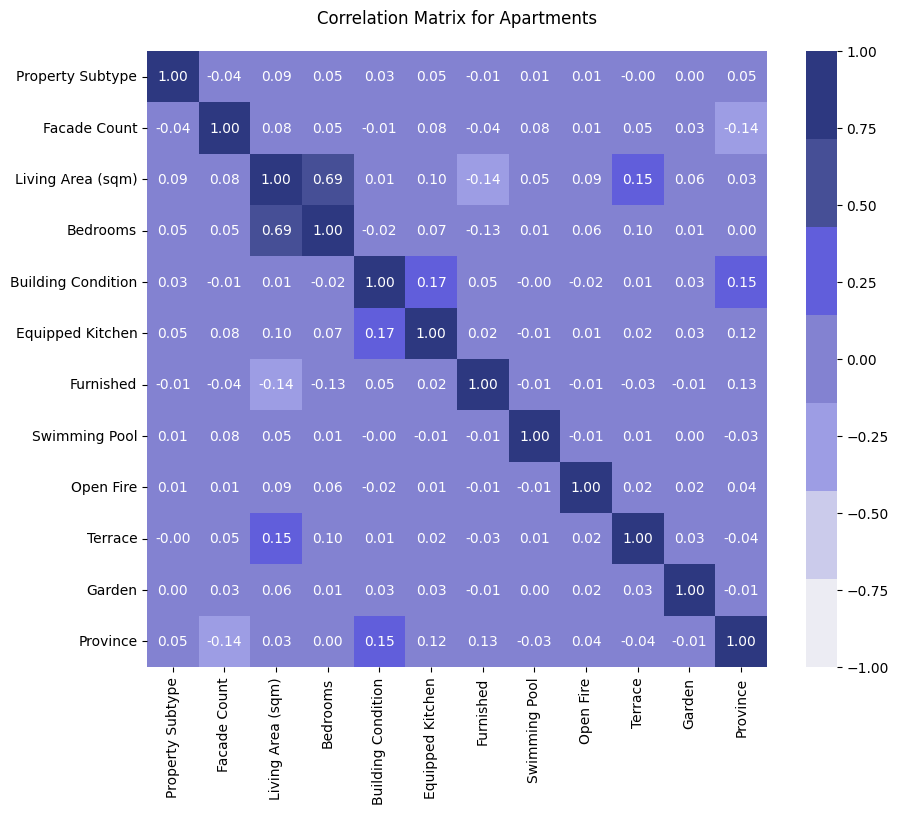

In [230]:
# Filter the DataFrame for apartments (excluding price)
# \ allows to break up the code across lines
corr_apartments = num_dfc[num_dfc['type_of_property'] == 0].corr() \
    .drop(index=['type_of_property', 'plot_surface', 'price'], columns=['type_of_property', 'plot_surface', 'price']) \
    .rename(index=custom_labels, columns=custom_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_apartments, annot=True, cmap=custom_cmap, fmt='.2f', vmin=-1, vmax=1)
plt.title("Correlation Matrix for Apartments", pad=20)
plt.show()

**Evaluation of Correlations Between Features for Apartments**

* Lower overall correlations.
  * The correlations in the apartment matrix are generally weaker compared to those for houses.
  * Less features with clear correlations

* Strong Correlation:
  * Living area and bedrooms (0.69): stronger than for houses with 0.54 -> apartments are more likely to have more rooms when they are bigger
  
* Slight Correlation:
  * Building condition and equipped kitchen (0.17): we can imagine that renovated apartments may come with equipped kitchen
  * Living area and terrace (0.15): larger apartments tend to come with terrace more than smaller ones -> for houses terrace is mostly related to garden
  
* Weak or No Correlation for Certain Features:
  * Garden, Swimming Pool, and Open Fire: have very weak to sometimes negative correlations with other features, highlighting that these features are rather unlikely for apartments

* Zero or Negative Correlations:
  * Living area and furnished (-0.14): For smaller apartments it's more likely to be furnished
  

**Summary:**

* Houses tend to have stronger correlations between features due to the presence of attributes like gardens, facades, and larger plot sizes, which strongly correlate with living area and property subtype.
* Apartments, have fewer features (e.g., gardens, facades) that correlate with other characteristics. The correlations are weaker overall, reflecting the more standardized nature of apartments in terms of size and feature availability.

### Exploring Correlations Between Price and Other Features

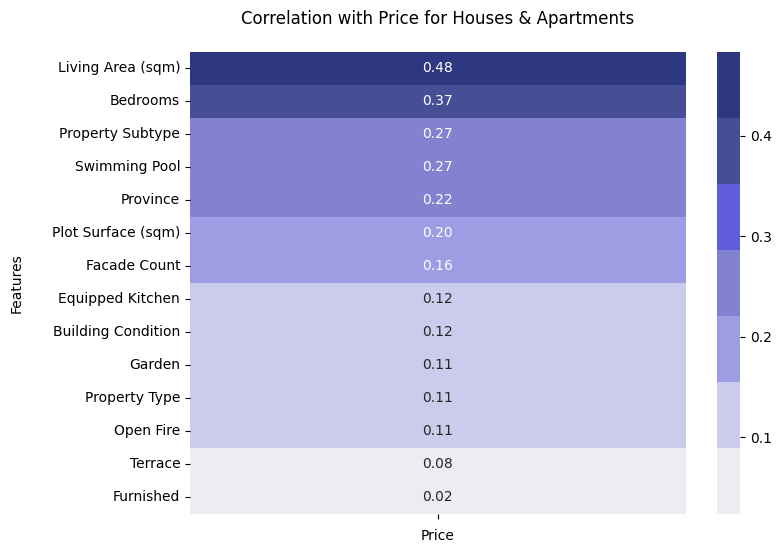

In [299]:
# Calculate the correlation matrix for all property types
corr_all_properties = num_dfc.corr().rename(index=custom_labels, columns=custom_labels)

# Select only correlations of 'price' with other features
corr_price = corr_all_properties[['price']].drop(index='price')

# Sort features by correlation with price
corr_price = corr_price.sort_values(by='price', ascending=False)

# Plot heatmap for all properties
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(corr_price, annot=True, cmap=custom_cmap, fmt=".2f", cbar=True)

# Remove or adjust the x-axis label
heatmap.set_xticklabels([''], rotation=0)  # Set to an empty string or rename it

plt.title("Correlation with Price for Houses & Apartments", pad=20)
plt.xlabel("Price")
plt.ylabel("Features", labelpad=20)
plt.show()


#### Heatmap of Correlations between Price and Other Features (Houses & Apartments Separately)

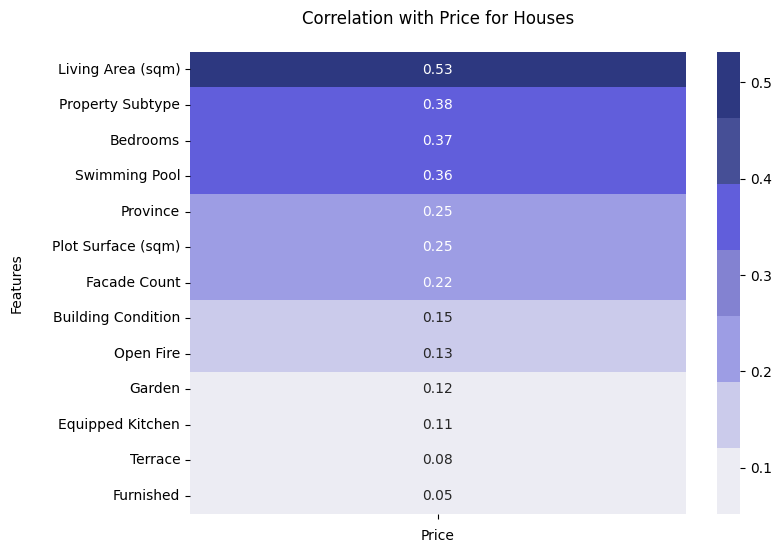

In [231]:
# Filter the DataFrame for houses (type_of_property == 1)
corr_houses = num_dfc[num_dfc['type_of_property'] == 1].corr() \
    .drop(index=['type_of_property'], columns=['type_of_property']) \
    .rename(index=custom_labels, columns=custom_labels)

# Select only correlations of 'price' with other features for houses
houses_corr_price = corr_houses[['price']].drop(index='price')

# Sort features by correlation with price
houses_corr_price = houses_corr_price.sort_values(by='price', ascending=False)

# Plot heatmap for houses
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(houses_corr_price, annot=True, cmap=custom_cmap, fmt=".2f", cbar=True)

# Remove or adjust the x-axis label
heatmap.set_xticklabels([''], rotation=0)  # Set to an empty string or rename it

plt.title("Correlation with Price for Houses", pad=20)
plt.xlabel("Price")
plt.ylabel("Features", labelpad=20)
plt.show()

**Evaluation of Correlations Between Price and Other Features For Houses**

The most important features regarding price are:

* Living area (the bigger the more expensive)
* Property subtype (since we ordered the subtypes by mean price)
* Number of bedrooms (aligns with living area)
* Swimming Pool (which is correlated to living area)
* Province -> locality

### Correlation Matrix Between Price and Other Features For Apartments

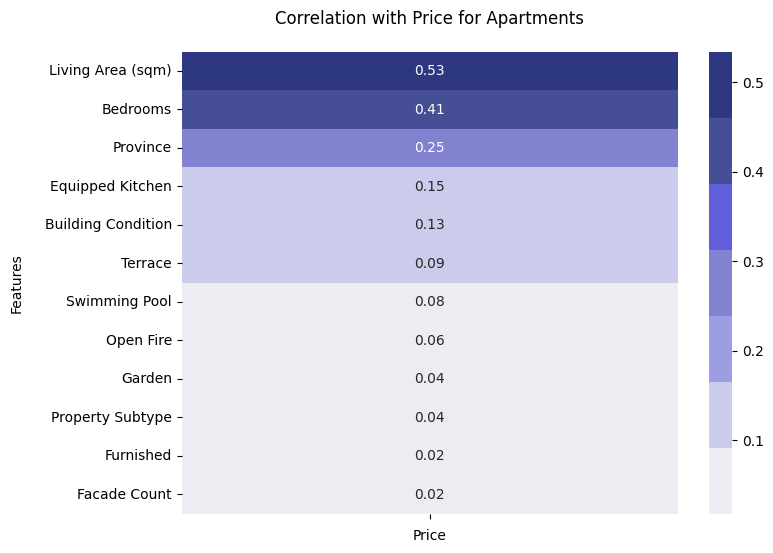

In [232]:
# Filter the DataFrame for apartments (type_of_property == 0)
corr_apartments = num_dfc[num_dfc['type_of_property'] == 0].corr() \
    .drop(index=['type_of_property', 'plot_surface'], columns=['type_of_property', 'plot_surface']) \
    .rename(index=custom_labels, columns=custom_labels)

# Select only correlations of 'price' with other features for apartments
apartments_corr_price = corr_apartments[['price']].drop(index='price')

# Sort features by correlation with price
apartments_corr_price = apartments_corr_price.sort_values(by='price', ascending=False)

# Plot heatmap for apartments
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(apartments_corr_price, annot=True, cmap=custom_cmap, fmt=".2f", cbar=True)

# Remove or adjust the x-axis label
heatmap.set_xticklabels([''], rotation=0)  # Set to an empty string or rename it

plt.title("Correlation with Price for Apartments", pad=20)
plt.xlabel("Price")
plt.ylabel("Features", labelpad=15)
plt.show()

**Evaluation of Correlations Between Price and Other Features**

Most important Features for Apartments:

- Living area (same as houses)
- Bedrooms (same)
- Province (same correlatio index, but higher in rank)
- Features like equipped kitchen and building condition

Logically weaker correlations:
- Swimming pool, open fire, garden since as we saw, overall weak correlations for apartments

Interesting/ surprising:

- Subtype of property have a much bigger impact on the price for houses than for apartments, probably since the luxury and extraordinary properties such as castles, manors, villas, etc. which have a high weight on price are more prevalent among houses than apartments

### Conclusion: Most and Least Important Features

**Most Important Features:**
* Living Area: Feature with biggest impact on price for houses and apartments
* Property Subtype: Less important for apartments, but large impact for houses
* Locality: Considerable impact for apartments as well as for houses
* Swimming Pool and Plot Surface: Less important for apartments but considerable impact on price for houses

Features such as number of bedrooms, of number of facades rank highly, but are closely connected with living area and can therefore be neglected.

**Least Important Features:**
* Furnished & Number of Facades: Features with lowest impact for apartments as well as houses.
* Open Fire: No significant impact
* Terrace Surface: Many properties have no information on the terrace surface, although it is indicated that a terrace exists. Since for an analysis of the terrace surface in correlation with price, the data is not sufficient, we would only focus on the question, if a terrace exists or not. 

#### **Correlation of living area and price**

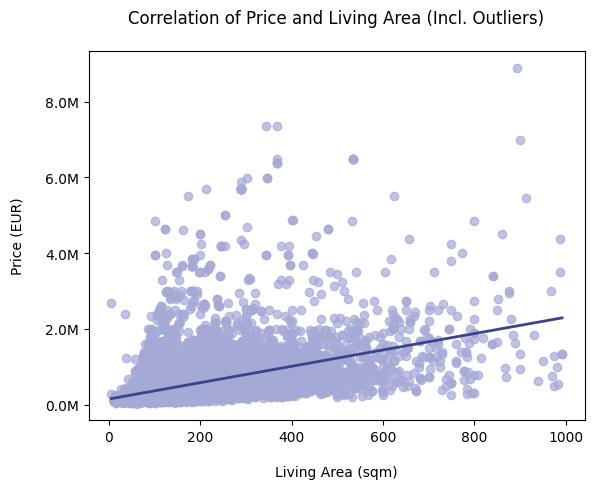

In [302]:
# Exploring relationships between price and other features (Price & Living Area incl. Outliers)

# Scatterplot with regression line
sns.regplot(
    x="living_area",
    y="price",
    data=dfc,  # data
    scatter_kws={"color": "#a5a9d6", "alpha": 0.7},  # Dots with lighter matching color
    line_kws={"color": "#3a438b", "lw": 2},  # Regression line color and width
    ci=None  # Remove confidence interval shading
)

# Format y-axis as millions
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{round(float(x / 1_000_000), 2)}M"))

# Labels and title
plt.xlabel("Living Area (sqm)", labelpad=15)
plt.ylabel("Price (EUR)", labelpad=15)
plt.title("Correlation of Price and Living Area (Incl. Outliers)", pad=20)

# Show the plot
plt.show()

#### Excluding Outliers

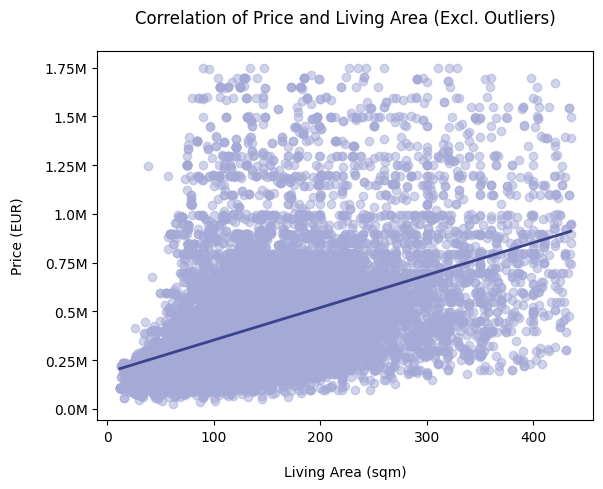

In [ ]:
# Calculate mean and standard deviation for price
mean_price = statistics.mean(dfc["price"])
std_price = statistics.stdev(dfc["price"])

# Calculate mean and standard deviation for living area
mean_area = statistics.mean(dfc["living_area"])
std_area = statistics.stdev(dfc["living_area"])

# Define lower and upper bounds (price)
price_lower_bound = mean_price - 3 * std_price
price_upper_bound = mean_price + 3 * std_price

# Define lower and upper bounds (living area)
area_lower_bound = mean_area - 3 * std_area
area_upper_bound = mean_area + 3 * std_area

# Filter out outliers (adjusted lower bound to filter out errors)
filtered_dfc = dfc[
    (dfc["price"] >= price_lower_bound) & (dfc["price"] <= price_upper_bound) &
    (dfc["living_area"] >= 12) & (dfc["living_area"] <= area_upper_bound)
]

# Scatterplot with regression line
sns.regplot(
    x="living_area",
    y="price",
    data=filtered_dfc,  # Filtered data
    scatter_kws={"color": "#a5a9d6", "alpha": 0.5},  # Dots with lighter matching color
    line_kws={"color": "#3a438b", "lw": 2},  # Regression line color and width
    ci=None  # Remove confidence interval shading
)

# Format y-axis as millions
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{round(float(x / 1_000_000), 2)}M"))

# Labels and title
plt.xlabel("Living Area (sqm)", labelpad=15)
plt.ylabel("Price (EUR)", labelpad=15)
plt.title("Correlation of Price and Living Area (Excl. Outliers)", pad=20)

# Show the plot
plt.show()


#### Comparing Price Range and Range of Living Area With and Without Outliers

In [306]:
print("Original price range:", dfc["price"].min(), "-", dfc["price"].max())
print("Original living area range:", dfc["living_area"].min(), "-", dfc["living_area"].max())

print("Filtered price range:", filtered_dfc["price"].min(), "-", filtered_dfc["price"].max())
print("Filtered living area range:", filtered_dfc["living_area"].min(), "-", filtered_dfc["living_area"].max())

Original price range: 27500.0 - 8900000.0
Original living area range: 5 - 992
Filtered price range: 27500.0 - 1750000.0
Filtered living area range: 12 - 435


In [ ]:
# Exploring relationships between price and other features (Price & Living Area using log transformation to compress large values)

# x-axis for variable controlled
# y-axis for outcome or response

dfc["log_price"] = np.log1p(dfc["price"])  # log1p handles log(0) safely
dfc["log_living_area"] = np.log1p(dfc["living_area"])

sns.scatterplot(x="log_living_area", y="log_price", data=dfc)
plt.xlabel("Log of Living Area", labelpad=15)
plt.ylabel("Log of Price", labelpad=15)
plt.title("Log-Transformed Price vs Living Area", pad=20)
plt.show()


### Average Price per Range of Living Area (incl. Outliers)

C:\Users\mstoe\AppData\Local\Temp\ipykernel_29616\2199122645.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_data = dfc.groupby("living_area_bin")["price"].mean().reset_index()


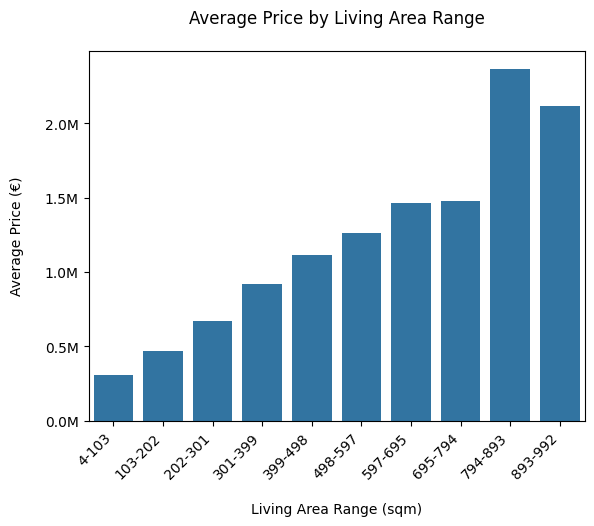

In [269]:
dfc["living_area_bin"] = pd.cut(dfc["living_area"], bins=10)

# Rename bin labels
dfc["living_area_bin"] = dfc["living_area_bin"].apply(
    lambda x: f"{int(x.left)}-{int(x.right)}" if pd.notnull(x) else "Unknown"
)

# Aggregate and plot
agg_data = dfc.groupby("living_area_bin")["price"].mean().reset_index()
sns.barplot(x="living_area_bin", y="price", data=agg_data)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{round(float(x / 1_000_000), 2)}M"))
plt.xticks(rotation=45, ha="right")
plt.title("Average Price by Living Area Range", pad=20)
plt.xlabel("Living Area Range (sqm)", labelpad=15)
plt.ylabel("Average Price (€)", labelpad=15)
plt.show()

C:\Users\mstoe\AppData\Local\Temp\ipykernel_29616\2019395791.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_data = dfc.groupby("living_area_bin")["price"].mean().reset_index()


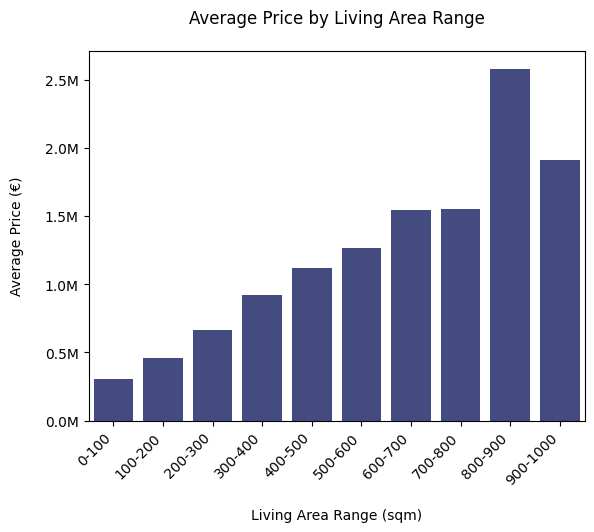

In [263]:
# Flatten bins

bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]  
labels = ["0-100", "100-200", "200-300", "300-400", "400-500", "500-600", "600-700", "700-800", "800-900", "900-1000"]

dfc["living_area_bin"] = pd.cut(dfc["living_area"], bins=bins, labels=labels)

# Aggregate and plot
agg_data = dfc.groupby("living_area_bin")["price"].mean().reset_index()

sns.barplot(
    x="living_area_bin",
    y="price",
    data=agg_data,
    color="#3a438b"  # Custom color for all bars
)

# Format y-axis as millions
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{round(float(x / 1_000_000), 2)}M"))

# Labels and Title
plt.xticks(rotation=45, ha="right")
plt.title("Average Price by Living Area Range", pad=20)
plt.xlabel("Living Area Range (sqm)", labelpad=15)
plt.ylabel("Average Price (€)", labelpad=15)
plt.show()

### Average Price per Range of Living Area (excl. Outliers)

C:\Users\mstoe\AppData\Local\Temp\ipykernel_29616\3606518536.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0-100', '0-100', '0-100', '100-200', '100-200', ..., '100-200', '100-200', '100-200', '200-300', '200-300']
Length: 25231
Categories (5, object): ['0-100' < '100-200' < '200-300' < '300-400' < '400-500']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  filtered_dfc.loc[:, "living_area_bin"] = pd.cut(filtered_dfc["living_area"], bins=bins, labels=labels)


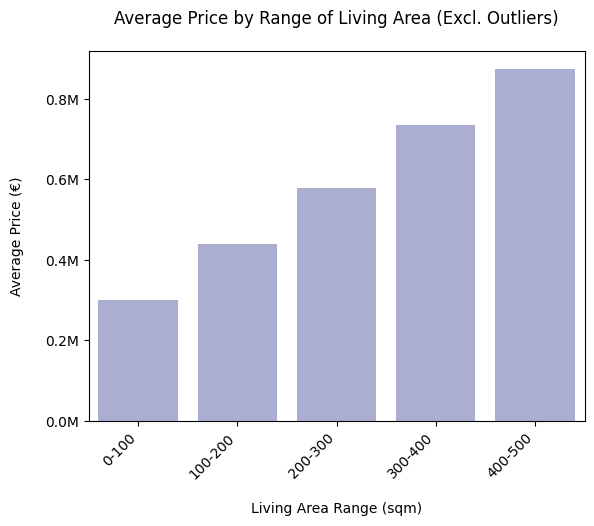

In [308]:
# Define bins and labels
bins = [0, 100, 200, 300, 400, 500]
labels = ["0-100", "100-200", "200-300", "300-400", "400-500"]

# Create living_area_bin column safely using .loc
filtered_dfc = filtered_dfc.copy()  # Ensure it's a copy, not a view
filtered_dfc.loc[:, "living_area_bin"] = pd.cut(filtered_dfc["living_area"], bins=bins, labels=labels)

# Aggregate data using the filtered DataFrame
agg_data = filtered_dfc.groupby("living_area_bin", observed=False)["price"].mean().reset_index()

# Bar plot
sns.barplot(
    x="living_area_bin",
    y="price",
    data=agg_data,
    color="#a5a9d6"  # Custom bar color
)

# Format y-axis as millions
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{round(float(x / 1_000_000), 2)}M"))

# Labels and Title
plt.xticks(rotation=45, ha="right")
plt.title("Average Price by Range of Living Area (Excl. Outliers)", pad=20)
plt.xlabel("Living Area Range (sqm)", labelpad=15)
plt.ylabel("Average Price (€)", labelpad=15)

# Show the plot
plt.show()


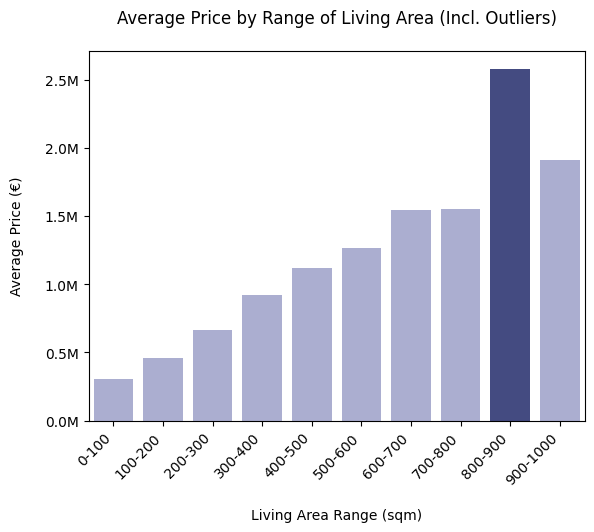

In [307]:
# Define bins and labels
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
labels = ["0-100", "100-200", "200-300", "300-400", "400-500", "500-600", "600-700", "700-800", "800-900", "900-1000"]

dfc["living_area_bin"] = pd.cut(dfc["living_area"], bins=bins, labels=labels)

# Aggregate data
agg_data = dfc.groupby("living_area_bin", observed=False)["price"].mean().reset_index()

# Define custom colors: lighter for most, darker for the 9th
colors = ["#a5a9d6"] * len(labels)  # Light shade for all
colors[8] = "#3a438b"  # Darker shade for the 9th bar (index 8)

# Plot
sns.barplot(
    x="living_area_bin",
    y="price",
    data=agg_data,
    palette=colors,  # Apply custom color palette
    hue=agg_data["living_area_bin"], # Set hue explicitely
    dodge=False,       # Ensure bards are not split
    legend=False       # Remove the hue legend
)

# Format y-axis as millions
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{round(float(x / 1_000_000), 2)}M"))

# Labels and title
plt.xticks(rotation=45, ha="right")
plt.title("Average Price by Range of Living Area (Incl. Outliers)", pad=20)
plt.xlabel("Living Area Range (sqm)", labelpad=15)
plt.ylabel("Average Price (€)", labelpad=15)

# Show the plot
plt.show()


**Evaluation of Correlation Between Living Area and Average Price**

* Both, the scatterplots and the bar plots show a similar trend with and without outliers, with steadily increasing price per increasing living area. 
* The comparison between the plots with and without outliers show however however a sharp cut in the dataset and since the data points calculated as outliers represent for the most part valid properties, we decided to include them.
* The only excluded data points are properties below 12 sqm as the price and other features show that these data points are errors.
* The impact of the outliers are most visible in the bar plot showing the distribution of the average price per range of living area, where they lead to the range from 800-900 sqm to be the most expensive.

In [81]:
# Check price average

filtered_df = dfc[(dfc["living_area"] > 900) & (dfc["living_area"] <= 1000)]

avg_price = filtered_df["price"].mean()
avg_price

np.float64(1910428.5714285714)

In [83]:
filtered_df = dfc[(dfc["living_area"] > 800) & (dfc["living_area"] <= 900)]

avg_price = filtered_df["price"].mean()
avg_price

np.float64(2581590.909090909)

### Histogram for number of properties according to their surface

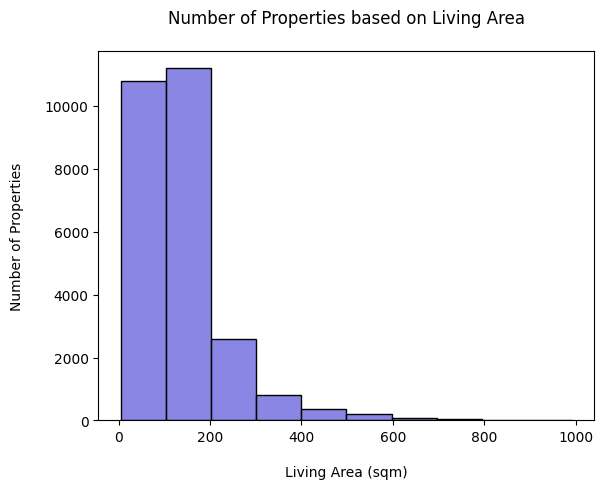

In [ ]:
# Histogram for the distribution of living area
sns.histplot(dfc["living_area"], kde=False, bins=10, color="#615edb")

# Adding labels and title
plt.xlabel("Living Area (sqm)", labelpad=15)
plt.ylabel("Number of Properties", labelpad=15)
plt.title("Number of Properties based on Living Area", pad=20)

# Show the plot
plt.show()


**Evaluation of the Distribution of Properties Based on Living Area**

* Shows a concentration of data points up to 200 sqm. 

* This confirms our calculation of outliers and the findings from the scatterplot above.